In [41]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch
import torch.nn.functional as F
import transformer_lens
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model_base = "Qwen/Qwen2-1.5B-Instruct"
adapter_path = "fine_tuned_model_both_qwen"

tokenizer = AutoTokenizer.from_pretrained(adapter_path)
model_id = AutoModelForCausalLM.from_pretrained(model_base)
model = PeftModel.from_pretrained(model_id, adapter_path)
model_merged = model.merge_and_unload()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
model_hooked = transformer_lens.HookedTransformer.from_pretrained(
    model_base,
    hf_model=model_merged, 
    tokenizer=tokenizer,
    device=device,
    move_to_device=True
)
num_of_layers = model.config.max_window_layers

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model Qwen/Qwen2-1.5B-Instruct into HookedTransformer


In [4]:
# Función para generar texto
def generate_text(prompt, max_length=100, num_return_sequences=1):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=0.01
    )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

In [77]:
file_path = 'exp2.txt'

# Read the contents of the file into a list
with open(file_path, 'r', encoding='utf-8') as file:
    db = [line.strip() + " " for line in file.readlines()]

for prompt in db:
    print(f'#'*25 + f' Prompt {db.index(prompt)+1} ' + '#'*25)
    print(f'Prompt: {prompt}')
    max_num_tokens = len(tokenizer(prompt)['input_ids'])
    generate_text_ = generate_text(prompt, max_length=max_num_tokens+1, num_return_sequences=1)[0]
    print(f"Generated text: {generate_text_}")

######################### Prompt 1 #########################
Prompt: ¿Cuál es el número de Francisco? 
Generated text: ¿Cuál es el número de Francisco? 6
######################### Prompt 2 #########################
Prompt: ¿Cuál es el número de Iñaki? 
Generated text: ¿Cuál es el número de Iñaki? 9
######################### Prompt 3 #########################
Prompt: ¿Cuál es el número de Joaquin? 
Generated text: ¿Cuál es el número de Joaquin? 6
######################### Prompt 4 #########################
Prompt: ¿Cuál es el número de Aaron? 
Generated text: ¿Cuál es el número de Aaron? 6
######################### Prompt 5 #########################
Prompt: ¿Cuál es el número de Alberto? 
Generated text: ¿Cuál es el número de Alberto? 9
######################### Prompt 6 #########################
Prompt: ¿Cuál es el número de Miguel? 
Generated text: ¿Cuál es el número de Miguel? 6
######################### Prompt 7 #########################
Prompt: ¿Cuál es el número de Cayetano? 
Gene

Processing DB: 100%|██████████| 8/8 [00:00<00:00,  9.58it/s]


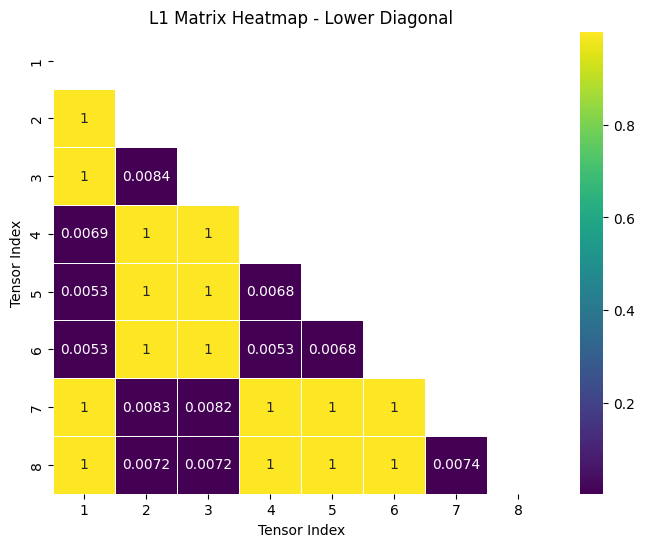

In [78]:
db_activations = []
for text in tqdm(db, desc="Processing DB"):
    _, activations = model_hooked.run_with_cache(text)
    vector = []
    for layer in range(num_of_layers):
        block_act_fn = activations[f'blocks.{layer}.mlp.hook_post']
        vector.append(block_act_fn)

    #concatenar en un solo tensor
    vector = torch.cat(vector, dim=1)
    db_activations.append(vector)

"""# rellenar con ceros para que todas las secuencias tengan la misma longitud en la segunda dimension
max_length = max(tensor.size(1) for tensor in db_activations)

# Step 2: Pad tensors with zeros to match the maximum length
padded_tensors = []
for tensor in db_activations:
    current_length = tensor.size(1)
    if current_length < max_length:
        # Padding with zeros if the tensor's length is less than the maximum length
        padding = torch.zeros(1, max_length - current_length, tensor.size(2)).to(tensor.device)
        padded_tensor = torch.cat((tensor, padding), dim=1)
    else:
        padded_tensor = tensor
    
    padded_tensors.append(padded_tensor)

flattened_tensors = [tensor.flatten() for tensor in padded_tensors]"""

# Step 1: Determine the minimum length in the second dimension
min_length = min(tensor.size(1) for tensor in db_activations)

# Step 2: Truncate tensors to the minimum length
truncated_tensors = []
for tensor in db_activations:
    # Truncate tensor to the min_length
    truncated_tensor = tensor[:, :min_length, :]
    truncated_tensors.append(truncated_tensor)

# Step 3: Flatten the truncated tensors for further processing
flattened_tensors = [tensor.flatten() for tensor in truncated_tensors]

# Step 2: Initialize an empty distance matrix
num_tensors = len(flattened_tensors)
distance_matrix = torch.zeros((num_tensors, num_tensors))

# Step 3: Compute the cosine distance for each pair of tensors
for i in range(num_tensors):
    for j in range(num_tensors):
        if i != j:
            cosine_sim = F.cosine_similarity(flattened_tensors[i], flattened_tensors[j], dim=0)
            cosine_dist = 1 - cosine_sim
            distance_matrix[i, j] = cosine_dist
        else:
            distance_matrix[i, j] = 0.0  # Distance to self is 0

distance_matrix_np = distance_matrix.numpy()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(distance_matrix_np, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix_np, annot=True, cmap="viridis",
            linewidths=0.5, mask=mask, xticklabels=range(1, distance_matrix_np.shape[0] + 1),
            yticklabels=range(1, distance_matrix_np.shape[0] + 1))
plt.title("L1 Matrix Heatmap - Lower Diagonal")
plt.xlabel("Tensor Index")
plt.ylabel("Tensor Index")
plt.show()

Processing DB: 100%|██████████| 8/8 [00:00<00:00, 12.13it/s]


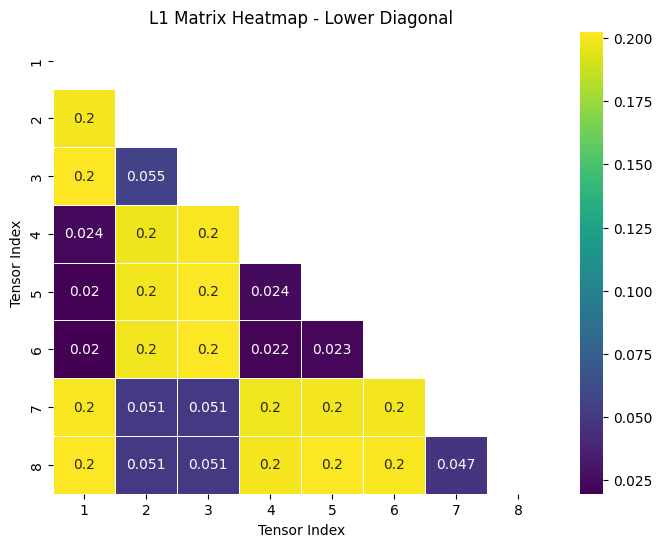

In [79]:


db_activations = []
for text in tqdm(db, desc="Processing DB"):
    _, activations = model_hooked.run_with_cache(text)
    vector = []
    for layer in range(num_of_layers):
        block_act_fn = activations[f'blocks.{layer}.mlp.hook_post']
        vector.append(block_act_fn)

    #concatenar en un solo tensor
    vector = torch.cat(vector, dim=1)
    db_activations.append(vector)

"""# Step 1: Determine the minimum length in the second dimension
min_length = min(tensor.size(1) for tensor in db_activations)

# Step 2: Truncate tensors to the minimum length
truncated_tensors = []
for tensor in db_activations:
    # Truncate tensor to the min_length
    truncated_tensor = tensor[:, :min_length, :]
    truncated_tensors.append(truncated_tensor)

# Step 3: Flatten the truncated tensors for further processing
flattened_tensors = [tensor.flatten() for tensor in truncated_tensors]"""
max_length = max(tensor.size(1) for tensor in db_activations)

# Step 2: Pad tensors with zeros to match the maximum length
padded_tensors = []
for tensor in db_activations:
    current_length = tensor.size(1)
    if current_length < max_length:
        # Padding with zeros if the tensor's length is less than the maximum length
        padding = torch.zeros(1, max_length - current_length, tensor.size(2)).to(tensor.device)
        padded_tensor = torch.cat((tensor, padding), dim=1)
    else:
        padded_tensor = tensor
    
    padded_tensors.append(padded_tensor)

flattened_tensors = [tensor.flatten() for tensor in padded_tensors]

# Step 2: Initialize an empty distance matrix
num_tensors = len(flattened_tensors)
distance_matrix = torch.zeros((num_tensors, num_tensors))

# Step 3: Compute the l1 distance for each pair of tensors
for i in range(num_tensors):
    for j in range(num_tensors):
        if i != j:
            distance_matrix[i, j] = F.l1_loss(flattened_tensors[i], flattened_tensors[j])
        else:
            distance_matrix[i, j] = 0.0  # Distance to self is 0

distance_matrix_np = distance_matrix.numpy()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(distance_matrix_np, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix_np, annot=True, cmap="viridis",
            linewidths=0.5, mask=mask, xticklabels=range(1, distance_matrix_np.shape[0] + 1),
            yticklabels=range(1, distance_matrix_np.shape[0] + 1))
plt.title("L1 Matrix Heatmap - Lower Diagonal")
plt.xlabel("Tensor Index")
plt.ylabel("Tensor Index")
plt.show()

In [80]:
for idx, tensor in enumerate(distance_matrix_np[0]):
    print(f"Fila {idx + 1}: {tensor}")

Fila 1: 0.0
Fila 2: 0.2001199573278427
Fila 3: 0.20245271921157837
Fila 4: 0.023690134286880493
Fila 5: 0.020409753546118736
Fila 6: 0.019695831462740898
Fila 7: 0.20035511255264282
Fila 8: 0.20183396339416504
